In [21]:
import numpy as np 
import pandas as pd
import tensorflow as tf
from keras import layers 
import matplotlib.pyplot as plt

from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

In [22]:
data_dir = "/home/gabriel/machine_Learning/script/tumor_classification/tumor/"

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(200, 200))

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(200, 200))

Found 253 files belonging to 2 classes.
Using 203 files for training.


Found 253 files belonging to 2 classes.
Using 50 files for validation.


2024-06-25 10:23:04.338583: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


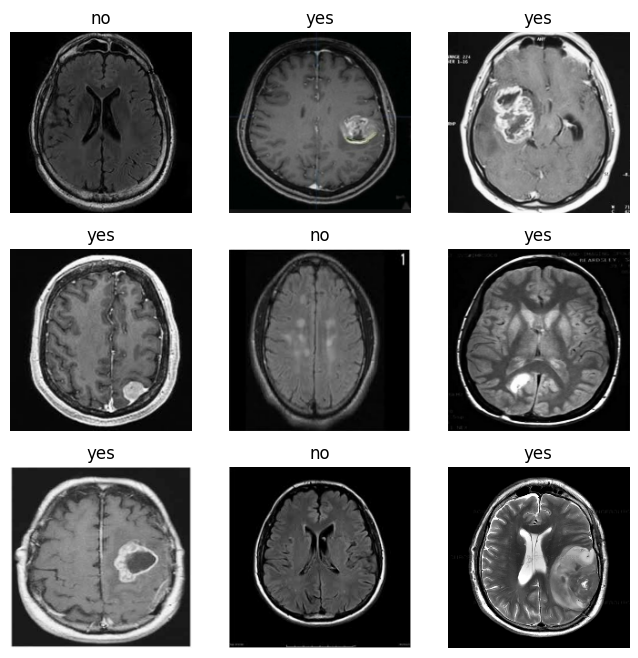

In [23]:
class_names = train_ds.class_names
plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [24]:
model = tf.keras.models.Sequential([
    layers.Rescaling(1./255, input_shape=(200, 200, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(), 
    layers.Dense(512, activation='relu'), 
    layers.BatchNormalization(), 
    layers.Dense(512, activation='relu'), 
    layers.Dropout(0.1), 
    layers.BatchNormalization(), 
    layers.Dense(512, activation='relu'), 
    layers.Dropout(0.2), 
    layers.BatchNormalization(), 
    layers.Dense(1, activation='sigmoid') 
]) 

optimizer = Adam(learning_rate=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])

/home/gabriel/.local/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [25]:
# history = model.fit(train_ds, epochs = 50, validation_data = val_ds, callbacks=[early_stopping])
# model.save("./model.h5")
# pd.DataFrame(history.history).plot(figsize=(8, 5))
# plt.gca().set_ylim(0, 1) 
# plt.show()

In [26]:
model = load_model('./model.h5')

In [27]:
images_test = []
labels_test = []

for images, labels in val_ds:
    images_test.append(images.numpy())
    labels_test.append(labels.numpy())

images_array_test = np.concatenate(images_test)
labels_array_test = np.concatenate(labels_test)

predictions = model.predict(images_array_test)

2024-06-25 10:23:05.217465: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step


Accuracy: 0.78
F1: 0.85
Recall: 1.0
Precision: 0.74
AUC: 0.69


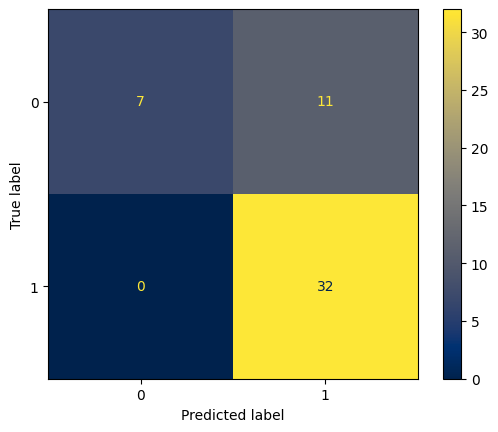

In [36]:
y_pred = (predictions > 0.3).astype("int")

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(labels_array_test, y_pred))
disp.plot(cmap='cividis', ax=plt.gca())

print("Accuracy:", accuracy_score(labels_array_test, y_pred).round(2))
print("F1:", f1_score(labels_array_test, y_pred).round(2))
print("Recall:",recall_score(labels_array_test, y_pred).round(2))
print("Precision:", precision_score(labels_array_test, y_pred).round(2))
print("AUC:", roc_auc_score(labels_array_test, y_pred).round(2))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
predict: [[0.8574556]]
real: yes


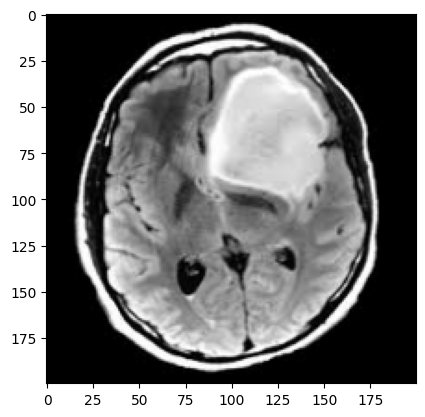

In [38]:
sample_index = np.random.randint(0, 50)
sample = np.expand_dims(images_array_test[sample_index], axis=0)

plt.imshow(images_array_test[sample_index].astype("uint8"))
print('predict:', model.predict(sample))
print('real:', class_names[labels_array_test[sample_index]])